<a href="https://colab.research.google.com/github/Hafsa620/PAI-LAB/blob/main/Binary_vs_Multiclass_classification_(APR).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Binary classification (Cats vs. Dogs)

In [ ]:
from google.colab import files
files.upload()  # upload your kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d bhavikjikadara/dog-and-cat-classification-dataset
!unzip dog-and-cat-classification-dataset.zip -d ./data


Streaming output truncated to the last 5000 lines.
  inflating: ./data/PetImages/Dog/778.jpg  
  inflating: ./data/PetImages/Dog/7780.jpg  
  inflating: ./data/PetImages/Dog/7781.jpg  
  inflating: ./data/PetImages/Dog/7782.jpg  
  inflating: ./data/PetImages/Dog/7783.jpg  
  inflating: ./data/PetImages/Dog/7784.jpg  
  inflating: ./data/PetImages/Dog/7785.jpg  
  inflating: ./data/PetImages/Dog/7786.jpg  
  inflating: ./data/PetImages/Dog/7787.jpg  
  inflating: ./data/PetImages/Dog/7788.jpg  
  inflating: ./data/PetImages/Dog/7789.jpg  
  inflating: ./data/PetImages/Dog/779.jpg  
  inflating: ./data/PetImages/Dog/7790.jpg  
  inflating: ./data/PetImages/Dog/7791.jpg  
  inflating: ./data/PetImages/Dog/7792.jpg  
  inflating: ./data/PetImages/Dog/7793.jpg  
  inflating: ./data/PetImages/Dog/7794.jpg  
  inflating: ./data/PetImages/Dog/7795.jpg  
  inflating: ./data/PetImages/Dog/7796.jpg  
  inflating: ./data/PetImages/Dog/7797.jpg  
  inflating: ./data/PetImages/Dog/7798.jpg  
  infl

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tqdm import tqdm
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# Data Augmentation
train_transform = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

test_transform = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])


In [ ]:
# Load Dataset
data_dir = "/content/data/PetImages"

dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)
print("Total images:", len(
  dataset))


Total images: 24998


In [ ]:
# Split Dataset
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


In [ ]:
print("Training samples:", len(train_dataset))
print("Testing samples:", len(test_dataset))
print("Classes:", dataset.classes)

Training samples: 19998
Testing samples: 5000
Classes: ['Cat', 'Dog']


In [ ]:
# Apply test transform to test set
test_dataset.dataset.transform = test_transform

In [ ]:
# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

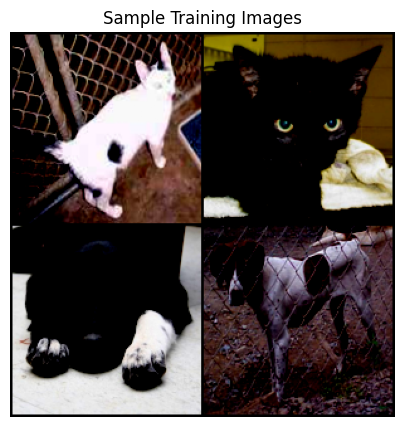

In [ ]:
# Show 2×2 Grid
images, labels = next(iter(train_loader))
grid = make_grid(images[:4], nrow=2)
plt.figure(figsize=(5,5))
plt.imshow(grid.permute(1,2,0))
plt.title("Sample Training Images")
plt.axis("off")
plt.show()


In [ ]:
# CNN Model (3 Convs)
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),
            nn.Linear(128*17*17, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

model = CNN()
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)


CNN(
  (net): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=36992, out_features=128, bias=True)
    (11): ReLU()
    (12): Linear(in_features=128, out_features=1, bias=True)
    (13): Sigmoid()
  )
)

In [ ]:
from tqdm import tqdm

# Training loop
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_acc_list, val_acc_list = [], []
train_loss_list, val_loss_list = [], []

for epoch in range(5):
    print(f"\nEpoch {epoch+1}/5")
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    # tqdm training bar
    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.float().to(device)

        optimizer.zero_grad()
        outputs = model(images).squeeze()
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = (outputs > 0.5).int()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    train_loss = running_loss / len(train_loader)

    # ------- Validation ----------
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss_total = 0

    # tqdm validation bar
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Validating", leave=False):
            images, labels = images.to(device), labels.float().to(device)
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)

            val_loss_total += loss.item()
            preds = (outputs > 0.5).int()
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total
    val_loss = val_loss_total / len(test_loader)

    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    val_acc_list.append(val_acc)
    val_loss_list.append(val_loss)

    print(f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")



Epoch 1/5


Training:  84%|████████▍ | 525/625 [01:13<00:12,  7.95it/s]/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Train Acc: 0.6903 | Val Acc: 0.7648

Epoch 2/5


Train Acc: 0.7839 | Val Acc: 0.8098

Epoch 3/5


Train Acc: 0.8371 | Val Acc: 0.8280

Epoch 4/5


Train Acc: 0.8836 | Val Acc: 0.8268

Epoch 5/5


Train Acc: 0.9331 | Val Acc: 0.8228


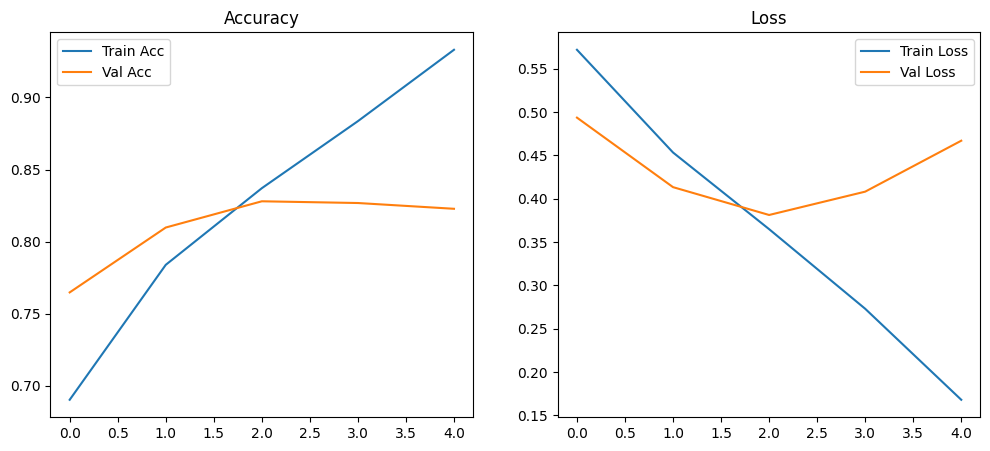

In [ ]:
# Accuracy/Loss Plots
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_acc_list, label="Train Acc")
plt.plot(val_acc_list, label="Val Acc")
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(train_loss_list, label="Train Loss")
plt.plot(val_loss_list, label="Val Loss")
plt.legend()
plt.title("Loss")

plt.show()


Final Test Accuracy: 0.8228


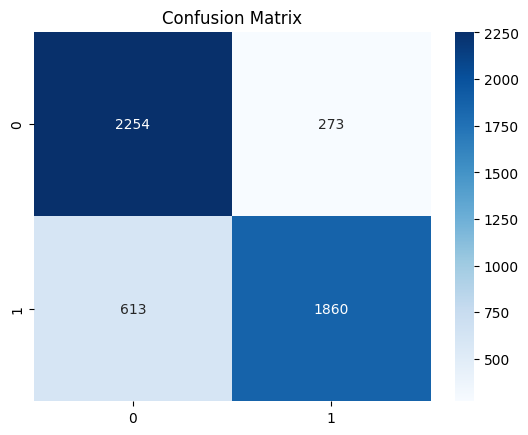

              precision    recall  f1-score   support

         Cat       0.79      0.89      0.84      2527
         Dog       0.87      0.75      0.81      2473

    accuracy                           0.82      5000
   macro avg       0.83      0.82      0.82      5000
weighted avg       0.83      0.82      0.82      5000



In [ ]:
import numpy as np
# Test Accuracy + Confusion Matrix
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images).squeeze()
        preds = (outputs > 0.5).int().cpu().numpy()

        y_pred.extend(preds)
        y_true.extend(labels.numpy())

# Accuracy
print("Final Test Accuracy:", (np.array(y_true) == np.array(y_pred)).mean())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_true, y_pred, target_names=["Cat","Dog"]))


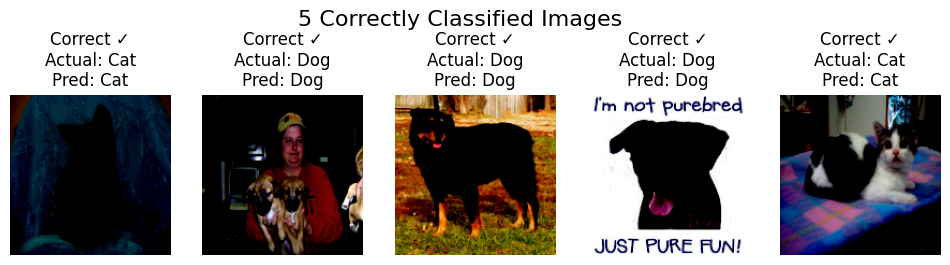

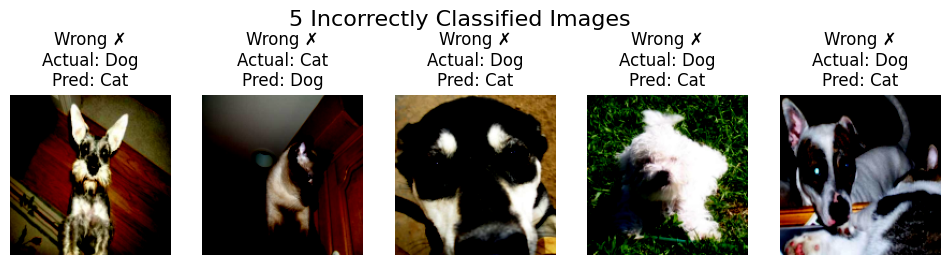

In [ ]:
# Put model into evaluation mode
model.eval()

correct_imgs = []
incorrect_imgs = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).squeeze()
        preds = (outputs > 0.5).long()

        for i in range(len(labels)):
            img = images[i].cpu().permute(1, 2, 0).numpy()
            img = np.clip(img, 0, 1)

            actual = labels[i].item()
            predicted = preds[i].item()

            if actual == predicted and len(correct_imgs) < 5:
                correct_imgs.append((img, actual, predicted))
            elif actual != predicted and len(incorrect_imgs) < 5:
                incorrect_imgs.append((img, actual, predicted))

        if len(correct_imgs) == 5 and len(incorrect_imgs) == 5:
            break

class_names = train_dataset.dataset.classes  # ['Cat', 'Dog']

# ---- DISPLAY CORRECT PREDICTIONS ----
plt.figure(figsize=(12, 6))
for idx, (img, actual, pred) in enumerate(correct_imgs):
    plt.subplot(2, 5, idx + 1)
    plt.imshow(img)
    plt.title(f"Correct ✓\nActual: {class_names[actual]}\nPred: {class_names[pred]}")
    plt.axis('off')
plt.suptitle("5 Correctly Classified Images", fontsize=16)
plt.show()

# ---- DISPLAY INCORRECT PREDICTIONS ----
plt.figure(figsize=(12, 6))
for idx, (img, actual, pred) in enumerate(incorrect_imgs):
    plt.subplot(2, 5, idx + 1)
    plt.imshow(img)
    plt.title(f"Wrong ✗\nActual: {class_names[actual]}\nPred: {class_names[pred]}")
    plt.axis('off')
plt.suptitle("5 Incorrectly Classified Images", fontsize=16)
plt.show()


 Multi-Class Image Classification (Cats vs Dogs vs Pandas)

In [ ]:
!kaggle datasets download -d ashishsaxena2209/animal-image-datasetdog-cat-and-panda

Dataset URL: https://www.kaggle.com/datasets/ashishsaxena2209/animal-image-datasetdog-cat-and-panda
License(s): unknown
 76% 284M/376M [00:05<00:02, 43.4MB/s]
100% 376M/376M [00:05<00:00, 66.4MB/s]


In [ ]:
!unzip animal-image-datasetdog-cat-and-panda.zip -d ./data

Streaming output truncated to the last 5000 lines.
  inflating: ./data/animals/animals/dogs/dogs_00007.jpg  
  inflating: ./data/animals/animals/dogs/dogs_00008.jpg  
  inflating: ./data/animals/animals/dogs/dogs_00009.jpg  
  inflating: ./data/animals/animals/dogs/dogs_00010.jpg  
  inflating: ./data/animals/animals/dogs/dogs_00011.jpg  
  inflating: ./data/animals/animals/dogs/dogs_00012.jpg  
  inflating: ./data/animals/animals/dogs/dogs_00013.jpg  
  inflating: ./data/animals/animals/dogs/dogs_00014.jpg  
  inflating: ./data/animals/animals/dogs/dogs_00015.jpg  
  inflating: ./data/animals/animals/dogs/dogs_00016.jpg  
  inflating: ./data/animals/animals/dogs/dogs_00017.jpg  
  inflating: ./data/animals/animals/dogs/dogs_00018.jpg  
  inflating: ./data/animals/animals/dogs/dogs_00019.jpg  
  inflating: ./data/animals/animals/dogs/dogs_00020.jpg  
  inflating: ./data/animals/animals/dogs/dogs_00021.jpg  
  inflating: ./data/animals/animals/dogs/dogs_00022.jpg  
  inflating: ./data/a

In [ ]:
data_dir = "/content/data/animals/animals"

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

data = datasets.ImageFolder(data_dir, transform=train_transform)

class_names = data.classes
print("Classes:", class_names)


Classes: ['cats', 'dogs', 'panda']


In [ ]:
# Split into train(80%) + val(20%)
train_size = int(0.8 * len(data))
val_size = len(data) - train_size

train_dataset, val_dataset = random_split(data, [train_size, val_size])
val_dataset.dataset.transform = test_transform  # Use test transform for validation

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
print("Training samples:", len(train_dataset))
print("Testing samples:", len(val_dataset))
print("Classes:", class_names)

Training samples: 2400
Testing samples: 600
Classes: ['cats', 'dogs', 'panda']


In [ ]:
import torchvision.models as models
# Fine-Tune ResNet18
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Replace last layer for 3 classes
model.fc = nn.Linear(model.fc.in_features, 3)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 133MB/s]


In [ ]:
# Training Loop + Accuracy/Loss Tracking
num_epochs = 8

train_acc_list = []
val_acc_list = []
train_loss_list = []
val_loss_list = []

for epoch in range(num_epochs):
    model.train()
    total, correct, running_loss = 0, 0, 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct/total
    train_loss = running_loss / len(train_loader)

    # --- Validation ---
    model.eval()
    val_correct, val_total, val_loss_sum = 0, 0, 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)

            loss = criterion(outputs, labels)
            val_loss_sum += loss.item()

            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total
    val_loss = val_loss_sum / len(val_loader)

    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")


Epoch 1/8 | Train Acc: 0.9550 | Val Acc: 0.9850
Epoch 2/8 | Train Acc: 0.9979 | Val Acc: 0.9883
Epoch 3/8 | Train Acc: 0.9975 | Val Acc: 0.9833
Epoch 4/8 | Train Acc: 0.9979 | Val Acc: 0.9833
Epoch 5/8 | Train Acc: 1.0000 | Val Acc: 0.9850
Epoch 6/8 | Train Acc: 0.9988 | Val Acc: 0.9767
Epoch 7/8 | Train Acc: 0.9967 | Val Acc: 0.9817
Epoch 8/8 | Train Acc: 0.9975 | Val Acc: 0.9833


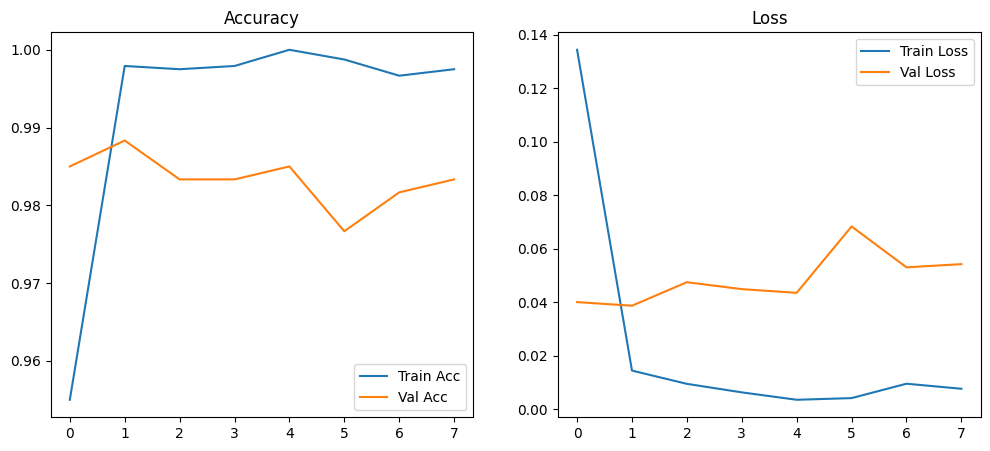

In [ ]:
# Plot Accuracy + Loss Curves
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_acc_list, label="Train Acc")
plt.plot(val_acc_list, label="Val Acc")
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_loss_list, label="Train Loss")
plt.plot(val_loss_list, label="Val Loss")
plt.title("Loss")
plt.legend()

plt.show()


In [ ]:
# Evaluation: Per-Class Accuracy + Confusion Matrix
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# ---- Classification Report ----
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))




Classification Report:
              precision    recall  f1-score   support

        cats       0.97      0.98      0.98       189
        dogs       0.99      0.97      0.98       221
       panda       0.99      0.99      0.99       190

    accuracy                           0.98       600
   macro avg       0.98      0.98      0.98       600
weighted avg       0.98      0.98      0.98       600



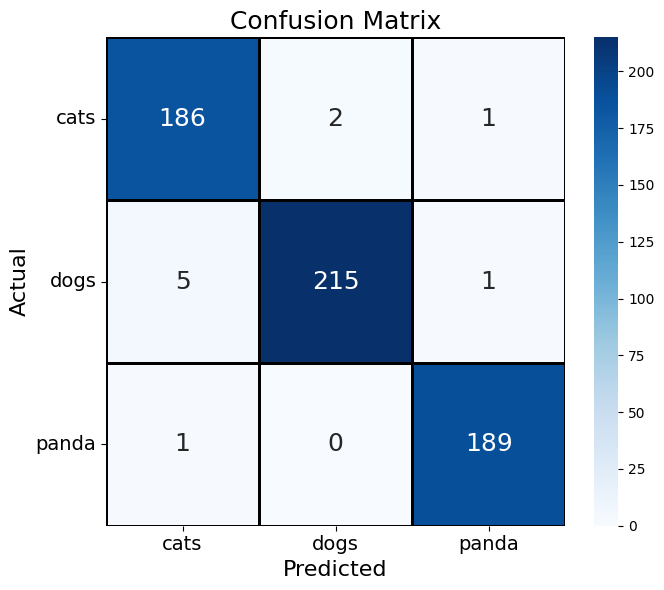

In [ ]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(7,6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    linewidths=1,
    linecolor='black',
    annot_kws={"size": 18}
)

plt.xticks(ticks=np.arange(len(class_names))+0.5, labels=class_names, fontsize=14)
plt.yticks(ticks=np.arange(len(class_names))+0.5, labels=class_names, fontsize=14, rotation=0)

plt.xlabel("Predicted", fontsize=16)
plt.ylabel("Actual", fontsize=16)
plt.title("Confusion Matrix", fontsize=18)
plt.tight_layout()
plt.show()


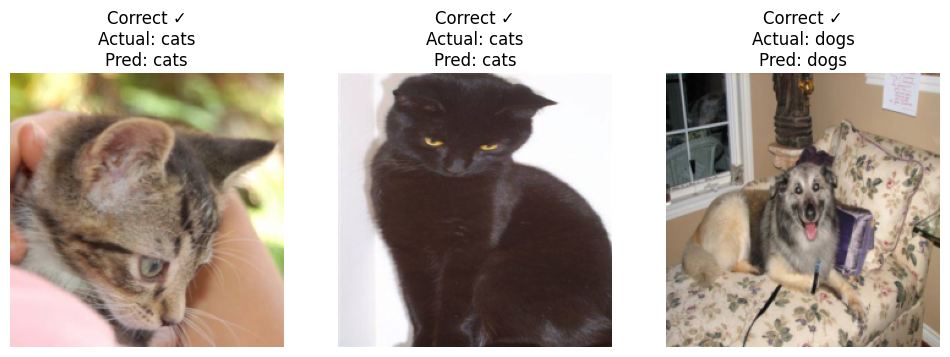

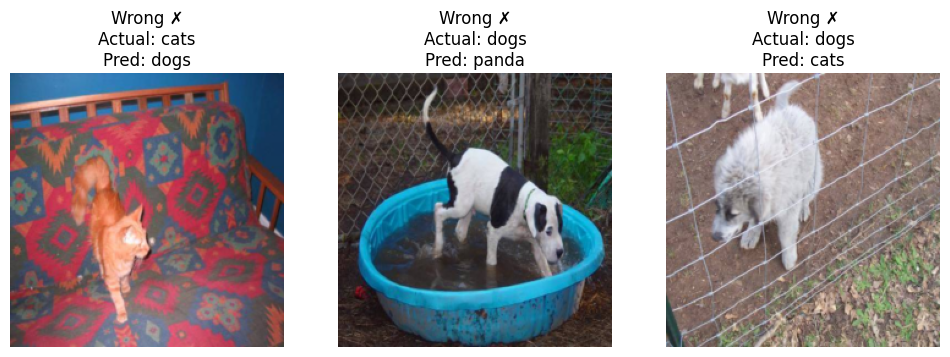

In [ ]:
# 3 correct plus incorrect predictions
correct_samples = []
incorrect_samples = []

model.eval()

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)

        for i in range(len(labels)):
            img = imgs[i].cpu().permute(1,2,0).numpy()
            img = (img * np.array([0.229, 0.224, 0.225]) +
                        np.array([0.485, 0.456, 0.406]))
            img = np.clip(img, 0, 1)

            actual = labels[i].item()
            pred   = preds[i].item()

            if actual == pred and len(correct_samples) < 3:
                correct_samples.append((img, actual, pred))
            elif actual != pred and len(incorrect_samples) < 3:
                incorrect_samples.append((img, actual, pred))

        if len(correct_samples) == 3 and len(incorrect_samples) == 3:
            break

# ----------- PLOTTING --------------
plt.figure(figsize=(12,4))
for idx, (img, actual, pred) in enumerate(correct_samples):
    plt.subplot(1,3,idx+1)
    plt.imshow(img)
    plt.title(f"Correct ✓\nActual: {class_names[actual]}\nPred: {class_names[pred]}")
    plt.axis('off')
plt.show()

plt.figure(figsize=(12,4))
for idx, (img, actual, pred) in enumerate(incorrect_samples):
    plt.subplot(1,3,idx+1)
    plt.imshow(img)
    plt.title(f"Wrong ✗\nActual: {class_names[actual]}\nPred: {class_names[pred]}")
    plt.axis('off')
plt.show()
